In [1]:
from pandas_datareader.data import DataReader
import numpy as np
import plotly.graph_objs as go
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from stockstats import StockDataFrame
from sklearn.preprocessing import MinMaxScaler
from statistics import variance
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


def predict(num_prediction, model):
    prediction_list = test_X[-2:]

    for i in range(num_prediction):
        x = prediction_list[-1:]
        out = [float(model.predict(x)[-1:])]
        x = x.reshape(-1)
        for var in range(n_vars-1):
            out.append(x[var+1] + x[var+1] - prediction_list[-2,0,var+1])
        prediction_list = prediction_list.reshape(i+2,prediction_list.shape[2])
        prediction_list = np.vstack([prediction_list, out])
        prediction_list = prediction_list.reshape(i+3,1,prediction_list.shape[1])
    
    return prediction_list


def predict_dates(num_prediction):
    last_date = data.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction + 1).tolist()
    prediction_dates.pop(0)
    return prediction_dates

                 Close
Date                  
2018-01-02   43.064999
2018-01-03   43.057499
2018-01-04   43.257500
2018-01-05   43.750000
2018-01-08   43.587502
...                ...
2022-06-13  131.880005
2022-06-14  132.759995
2022-06-15  135.429993
2022-06-16  130.059998
2022-06-17  131.559998

[1124 rows x 1 columns]


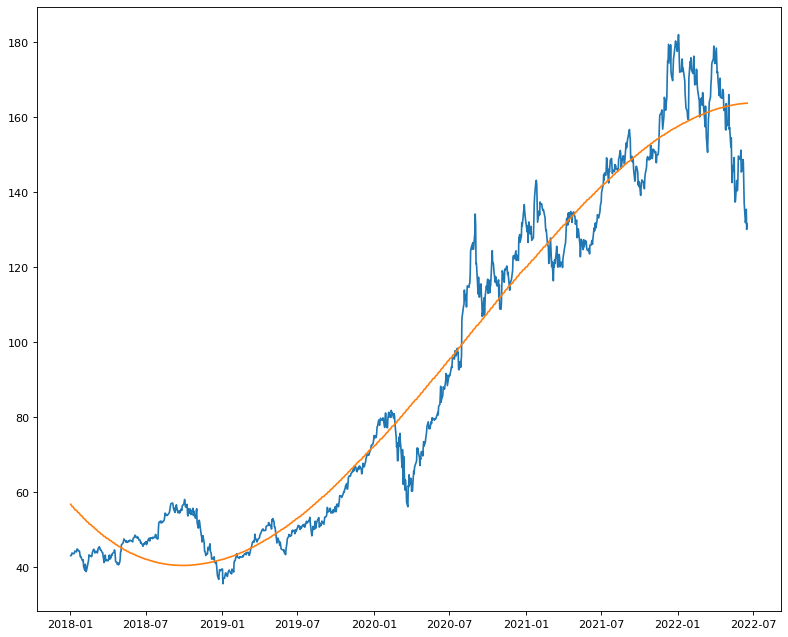

In [2]:
user_input = input('Input the ticker:')
# df = DataReader(user_input, data_source='yahoo', start='2018-01-01', end=datetime.now())
df = DataReader(user_input, data_source='yahoo', start='2018-01-01', end=datetime.now()- timedelta(days=7))
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
print(data)

# Convert the dataframe to a numpy array
dataset = data.values
date = data.index

date_number = np.linspace(1,len(date),len(date))
dataset = dataset.flatten()
mymodel = np.poly1d(np.polyfit(date_number, dataset, 3))
plt.figure(figsize=(12, 10), dpi=80)
plt.plot(date, dataset)
plt.plot(date, mymodel(date_number))
plt.show()

In [3]:
fold = 4
n_in=1
n_out=1
dropnan = True


close_data_df = StockDataFrame.retype(df)
close_data_df.init_all()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled= scaler.fit_transform(close_data_df[['close']])

scaled_df = pd.DataFrame(scaled)
scaled_df.index = close_data_df.index
scaled_df.columns = ['close']

close_data_df = close_data_df.filter(['macds','macd'])
close_data_df = pd.concat([scaled_df,close_data_df],axis=1)

print(close_data_df.corr())
close_data_df.head()

n_vars = 1 if type(data) is list else close_data_df.shape[1]
cols, names = list(), list()
# input sequence (t-n, ... t-1)
for i in range(n_in, 0, -1):
    cols.append(close_data_df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
for i in range(0, n_out):
    cols.append(close_data_df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
supervised_df = pd.concat(cols, axis=1)
supervised_df.columns = names
# drop rows with NaN values
if dropnan:
    supervised_df.dropna(inplace=True)
supervised_df = supervised_df.drop(supervised_df.columns[-n_vars+1:], axis=1)
# return agg

#series_to_supervised(close_data_df)
supervised_df.head()

supervised_data = supervised_df.to_numpy()

close_data = close_data_df.to_numpy()
remainder = close_data.shape[0]%5
close_data = close_data[remainder:]
close_data_df = close_data_df.drop(close_data_df.index[range(0,remainder)])
print(close_data_df)

kfold=KFold(fold,True,7)

X = supervised_data[:,0:3]
y = supervised_data[:,3:]

          close     macds      macd
close  1.000000  0.181486  0.160312
macds  0.181486  1.000000  0.952314
macd   0.160312  0.952314  1.000000
               close     macds      macd
Date                                    
2018-01-08  0.054895  0.016476  0.030504
2018-01-09  0.054860  0.020730  0.032170
2018-01-10  0.054792  0.023641  0.032231
2018-01-11  0.056482  0.028419  0.043525
2018-01-12  0.059572  0.038749  0.073134
...              ...       ...       ...
2022-06-13  0.657728 -3.288622 -3.779681
2022-06-14  0.663736 -3.493695 -4.313987
2022-06-15  0.681966 -3.689046 -4.470449
2022-06-16  0.645302 -3.945329 -4.970464
2022-06-17  0.655543 -4.193446 -5.185911

[1120 rows x 3 columns]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=7 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [4]:
run = True
mae_list = []
forecast_list = []
num_trials = 11
split_percent = 0.8
num_prediction = 10
num_epochs = 25
batch_size = 32
num_trials = 3
num_repeat = 1
threshold = 10


while run == True:
    if num_repeat == 1:
        print('Start training...\n')
    for _ in range(num_trials):
        i = 1
        for train, test in kfold.split(X,y):
            if i < 4:
                i += 1
                train_X, test_X = X[train],X[test]
                train_y, test_y = y[train],y[test]
                date_train, date_test = date[train], date[test]  
                train_X = train_X.reshape(-1, 1, train_X.shape[1])
                test_X  = test_X.reshape(-1, 1, test_X.shape[1])
                train_y = train_y.reshape(-1, 1, train_y.shape[1])
                test_y = test_y.reshape(-1, 1, test_y.shape[1])


                model = Sequential()

                model.add(
                    LSTM(50,
                        activation='relu'))
                        #return_sequences=True,)
        #         )
                model.add(Dropout(0.2))
                # model.add(LSTM(128, return_sequences=True, input_shape= (date_train.shape[0], 1)))
                # model.add(LSTM(64, return_sequences=False))
                # model.add(Dense(25))
                model.add(Dense(units=1))
                model.compile(optimizer='adam', loss='mse')

                history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, verbose=0, validation_data=(test_X, test_y))

                # get train_y
                train_y = train_y.reshape(train_y.shape[0],1)
                train_y = np.hstack([train_y, np.zeros(train_y.shape)])
                train_y = scaler.inverse_transform(train_y)
                train_y = train_y[:,:1]
                train_y = train_y.reshape((-1))

                # get test_y
                test_y = test_y.reshape((test_X.shape[0], test_X.shape[1]))
                inv_testy = np.hstack([test_y,np.zeros(test_y.shape)])
                inv_testy = scaler.inverse_transform(inv_testy)
                inv_testy = inv_testy[:,:1]
                test_y = inv_testy.reshape((-1))
                
                # Validate with test_X
                yhat = model.predict(test_X)
                yhat_df = pd.DataFrame(yhat)
                yhat_df.index = close_data_df.index[test-3]
                yhat_df.columns = ['Close']
                new_test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
                inv_yhat = np.concatenate((yhat_df, new_test_X[:,1:scaled_df.shape[1]]), axis=1)
                inv_yhat = scaler.inverse_transform(inv_yhat)
                prediction = inv_yhat[:,:1]
                prediction = prediction.reshape((-1))
                

                forecast = (predict(num_prediction, model))
                forecast = forecast.reshape(num_prediction + 2,forecast.shape[2])
                forecast = np.delete(forecast,slice(scaled_df.shape[1],forecast.shape[1]),1)
                forecast = scaler.inverse_transform(forecast)
                forecast = np.delete(forecast,slice(1,forecast.shape[1]),1)
                forecast = forecast.reshape((-1))
                print(forecast)
                forecast_list = np.append(forecast_list,np.array([forecast]))

                score = mean_absolute_error(test_y, prediction)
                mae_list.append(score)

    forecast_list = np.reshape(forecast_list,[3*num_repeat*num_trials,num_prediction + 2])
    forecasts = forecast_list[:,2:]
    forecast_5days = forecasts[:,:5]

    var_list = []
    for i in range(forecast_5days.shape[0]):
        var = variance(forecast_5days[i])
        var_list.append(var)    
    if min(var_list) > threshold:
        run = True
        print('\nRetraining...\n')
        num_repeat += 1
    else:
        run = False
        print(
            '\nMinimum of mae: ',min(mae_list),
            '\nAverage of mae: ',(sum(mae_list) - max(mae_list))/(len(mae_list) - 1),
            '\nMaximum of mae: ',max(mae_list)
        )

        var = np.var(forecast_5days,axis = 1)
        maxindex = np.argmax(var)
        
        print(forecast_5days)

        small_var_prediction = forecast_5days[var_list.index(min(var_list))]
        print('\nPrediction with smallest variance: ',small_var_prediction)
        print('mae: ',mae_list[var_list.index(min(var_list))])
        forecast_dates = predict_dates(num_prediction)
        trace1 = go.Scatter(
            x=date_train,
            y=train_y,
            mode='lines',
            name='Data'
        )
        trace2 = go.Scatter(
            x=date_test,
            y=prediction,
            mode='lines',
            name='Prediction'
        )
        trace3 = go.Scatter(
            x=date_test,
            y=test_y,
            mode='lines',
            name='Ground Truth'
        )
        layout = go.Layout(
            title="Stock",
            xaxis={'title': "Date"},
            yaxis={'title': "Close"}
        )
        trace4 = go.Scatter(
            x=forecast_dates,
            y=small_var_prediction,
            mode='lines',
            name='Future Prediction'
        )
        fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
        fig.show()

        small_mae_prediction = forecast_5days[mae_list.index(min(mae_list))]
        print('\nPrediction with best mae: ',small_mae_prediction)
        print('mae: ',min(mae_list))

        trace4 = go.Scatter(
            x=forecast_dates,
            y=small_mae_prediction,
            mode='lines',
            name='Future Prediction'
        )
        fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
        fig.show()

Start training...



2022-06-26 13:20:46.437280: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[132.75999451 130.05999756 122.96993108 116.29490833 109.60638924
 103.06552674  97.11516841  91.7241749   87.11802063  83.35820737
  80.42537669  78.28364455]
[147.96000671 135.42999268 133.19230886 132.83957075 133.37382853
 134.66121876 134.5365653  134.66576701 134.16899518 133.19039703
 132.07352686 130.91079008]
[146.13999939 142.63999939 135.68065513 129.89950739 125.0687604
 120.85453252 116.37709109 112.77211909 111.68264317 114.6338982
 121.35788665 130.68994246]
[132.75999451 130.05999756 129.57182393 129.08602552 128.68644306
 128.73253664 129.54713593 131.17563612 133.64707267 136.99285558
 141.39309899 146.82905121]
[147.96000671 135.42999268 138.0149982  145.26653118 156.49077215
 173.77129066 195.57868771 220.94801863 249.28874432 280.32247003
 313.95161355 350.22163993]
[146.13999939 142.63999939 140.59111433 139.15698413 138.21984401
 137.47324148 137.54310643 138.25123653 139.23179018 139.68904199
 139.65532733 140.30579681]
[132.75999451 130.05999756 130.15031583 13


Prediction with best mae:  [140.59111433 139.15698413 138.21984401 137.47324148 137.54310643]
mae:  1.8521318386485928


In [11]:
# score for forecast
actual_df =  DataReader(user_input, data_source='yahoo', start='2018-01-01', end=datetime.now())
actual_price = actual_df.filter(['Close'])
actual = actual_price[-5:]
print(actual)

my_choice = forecast_5days[-4]

print('\nmy choice: ',my_choice)
trace4 = go.Scatter(
    x=forecast_dates,
    y=my_choice,
    mode='lines',
    name='Future Prediction'
)
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
fig.show()

forecast_score = mean_absolute_error(my_choice,actual)
print('mae: ',forecast_score)

                 Close
Date                  
2022-06-17  131.559998
2022-06-21  135.869995
2022-06-22  135.350006
2022-06-23  138.270004
2022-06-24  141.660004

my choice:  [140.59111433 139.15698413 138.21984401 137.47324148 137.54310643]


mae:  4.020320742373224


In [6]:
# score for forecast
actual_df =  DataReader(user_input, data_source='yahoo', start='2018-01-01', end=datetime.now())
actual_price = actual_df.filter(['Close'])
actual = actual_price[-5:]
print(actual)

# seleted_forecast = forecast_5days[3]
# seleted_forecast = seleted_forecast.reshape(5,1)
# seleted_forecast = [143.69,144.59,146.14,148.19,150.65]
# seleted_forecast = [148.95,148.17,147.25,146.42,146.37]
print('\nForecast 5 days:\n',small_var_prediction)
forecast_score = mean_absolute_error(small_var_prediction,actual)
print('mae: ',forecast_score)
print('\nForecast 5 days:\n',small_mae_prediction)
forecast_score = mean_absolute_error(small_mae_prediction,actual)
print('mae: ',forecast_score)

                 Close
Date                  
2022-06-17  131.559998
2022-06-21  135.869995
2022-06-22  135.350006
2022-06-23  138.270004
2022-06-24  141.660004

Forecast 5 days:
 [129.57182393 129.08602552 128.68644306 128.73253664 129.54713593]
mae:  7.41720833063373

Forecast 5 days:
 [140.59111433 139.15698413 138.21984401 137.47324148 137.54310643]
mae:  4.020320742373224


In [7]:
# print(date_test.shape,date_train.shape)
# print(date.shape)
# print(train_y.shape,test_y.shape)
# print(supervised_test.shape)

In [8]:
# small_mae_prediction = forecast_5days[mae_list.index(min(mae_list))]
# print('\nPrediction with best mae: ',small_mae_prediction)
# trace1 = go.Scatter(
#     x=date_train,
#     y=train,
#     mode='lines',
#     name='Data'
# )
# trace2 = go.Scatter(
#     x=date_test,
#     y=prediction,
#     mode='lines',
#     name='Prediction'
# )
# trace3 = go.Scatter(
#     x=date_test,
#     y=test,
#     mode='lines',
#     name='Ground Truth'
# )
# layout = go.Layout(
#     title="Stock",
#     xaxis={'title': "Date"},
#     yaxis={'title': "Close"}
# )
# trace4 = go.Scatter(
#     x=forecast_dates,
#     y=small_mae_prediction,
#     mode='lines',
#     name='Future Prediction'
# )
# fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
# fig.show()

In [9]:
# plt.figure(figsize=(8, 6))
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.title('Model loss')
# plt.show()

In [10]:
# arraya = np.array([[1,2,3,40,5,6,7],[2,3,4,5,6,7,8],[3,4,5,6,7,8,9]])
# var = np.var(arraya,axis=1)
# maxindex = np.argmax(var)
# new_arraya = np.delete(arraya,maxindex,0)
# print(new_arraya)